In [1]:
import pandas as pd
import numpy as np
from database import engine
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import subprocess
from ingredient_map import create_ingredient_map
from quant_preprocess import query_data
from quant_preprocess import cols_to_lower
from quant_preprocess import get_cols_list
from quant_preprocess import query_and_preprocess_data
from quant_preprocess import shape_data_long
from quant_preprocess import merge_long
from quant_preprocess import pivot_wide
from quant_preprocess import recode_ingredients
import os


INPUT_PATH = os.path.join("..\\data", "ingredient_prices_clean.csv")
TABLE_DIR = "tables"
FIGURE_DIR = "figures"


df_drinks = query_and_preprocess_data()
df_prices = pd.read_csv(INPUT_PATH, header=None)
liquors = ["brandy","gin","tequila","vodka","whiskey","flavored rum","flavored vodka","cognac","bourbon","rum","scotch","grain alcohol"]

In [2]:
def create_dummies():
    df = query_and_preprocess_data()
    headers = df.columns[1:]
    d = {'strdrink': df['strdrink'].values.tolist()}
    for e in range(0, len(headers)):
        d[headers[e]] = (df[str(headers[e])] > 0).astype(int).values.tolist()
    return pd.DataFrame.from_dict(d)

In [3]:
def summmary_of_oz():
    
    df = query_and_preprocess_data()
    df = df.describe().transpose().sort_values('mean',
                                ascending = False).head(10)
    df = df[["mean"]]
    return df

In [4]:
def summary_of_usage():
    
    filename = os.path.join(TABLE_DIR, 'usage.tex')
    pdffile = os.path.join(TABLE_DIR,'usage.pdf')
    outname = os.path.join(TABLE_DIR,'usage.png')
    
    dum_df = create_dummies()
    #headers = dum_df.columns[1:].values.tolist() might be unnecessary
    data = dum_df.describe().transpose().sort_values('mean', 
                                    ascending=False).head(10)
    data = data[["mean"]]
    data = data.rename(columns={"mean":"Proportion of Drinks"})
    data.index.name = "Ingredient"
    
    template = r'''\documentclass[preview]{{standalone}}
    \usepackage{{booktabs}}
    \begin{{document}}
    {}
    \end{{document}}
    '''
    with open(filename, 'wt') as f:
        f.write(template.format(data.to_latex()))
    subprocess.call(['pdflatex', filename])
    subprocess.call(['convert', '-density', '300', pdffile, '-quality', '90', outname])
    return data
    

In [5]:
def get_amount_table():
    df = query_data()
    ingred_cols = get_cols_list(df, "stringredient")
    measure_cols = get_cols_list(df, "strmeasure")
    df[ingred_cols] = cols_to_lower(df, ingred_cols)
    ingredient_long = shape_data_long(
            df, ingred_cols, "stringredient", "", "ingredient"
        )
    measure_long = shape_data_long(df, measure_cols, "strmeasure", "_clean", "amount")
    combined_long = merge_long(ingredient_long, measure_long)
    ingredient_dict = create_ingredient_map()
    recoded_long = recode_ingredients(combined_long, ingredient_dict)
    combined_wide = pivot_wide(recoded_long)
    return combined_wide


In [21]:
def drop_big_drinks():
    # dropping things that wouldn't be defined as a "cocktail"
    # if it's less than two ounces or greater than 9, we drop it
    df = get_amount_table()
    df = df.set_index("strdrink")
    df = df.transpose()
    for d in df:
        if (df.sum(axis=0)[d] > 12):
            df = df.drop(d,axis=1)
    return df.columns.values.tolist()
    


In [22]:
def number_of_ingredients():
    
    ingreds = []
    drinks = drop_big_drinks()
    data = create_dummies()
    data = data.set_index("strdrink")
    data = data.transpose()[drinks]
    return data.sum(axis=0).tolist()

    

In [23]:
def prices_list():
    
    df_prices = pd.read_csv(INPUT_PATH, header=None)
    df_prices = df_prices.sort_values(0, ascending=True)
    df_prices = df_prices.transpose()
    prices = df_prices.loc[1].values.tolist()
    return prices

In [24]:
def combine_prices_ingredients():
    
    ingredients = get_amount_table()
    ingredients = ingredients.transpose()
    ingredients =  ingredients.drop(labels="strdrink",axis=0)
    prices = prices_list()
    ingredients["prices"] = prices
    return ingredients

In [25]:
def get_ingredient_cost():
    df = get_amount_table()
    drinks = df["strdrink"].values.tolist()
    df = combine_prices_ingredients()
    for i in range(0,627):
        df[i] = df[i]*df["prices"]
    df= df.transpose()
    df = df.drop(labels = "prices", axis = 0)
    df["strdrink"] = drinks
    df = df.transpose()
    return df

In [26]:
def drop_all_zero_dummies():

    liquors = ["brandy","gin","tequila","vodka","whiskey","flavored rum","flavored vodka","cognac","bourbon","rum","scotch","grain alcohol"]
    dummies = create_dummies()
    dummies = dummies[liquors].replace(0, np.nan)
    dummies = dummies.dropna(how='all', axis=0)
    dummies = dummies.replace(np.nan, 0)
    
    return dummies

In [27]:
pd.set_option('display.max_columns', None)

In [28]:
def most_popular_liquor_table():
    
    filename = os.path.join(TABLE_DIR, 'pop_liquor.tex')
    pdffile = os.path.join(TABLE_DIR,'pop_liquor.pdf')
    outname = os.path.join(TABLE_DIR,'pop_liquor.png')
    df = drop_all_zero_dummies()
    df = df.describe().transpose().sort_values('mean', 
                                        ascending=False).head(15)
    df = df[["mean"]]
    df = df.rename(columns={"mean":"Proportion of Drinks"})
    df.index.name = "Liquor"
    
#     template = r'''\documentclass[preview]{{standalone}}
#     \usepackage{{booktabs}}
#     \begin{{document}}
#     {}
#     \end{{document}}
#     '''
#     with open(filename, 'wt') as f:
#         f.write(template.format(data.to_latex()))
#     subprocess.call(['pdflatex', filename])
#     subprocess.call(['convert', '-density', '300', pdffile, '-quality', '90', outname])
    return df

In [29]:
def model_1():
    
    liquors = ["brandy","gin","tequila","vodka","whiskey","flavored rum","flavored vodka","cognac","bourbon","rum","scotch","grain alcohol"]
    number = number_of_ingredients()
    data = get_ingredient_cost()
    amounts = get_amount_table()
    data.columns = data.loc['strdrink']
    drinks = data.columns.values.tolist()
    data = data.drop("strdrink", axis=0)
    df_cost = data.transpose()
    cost = df_cost.sum(axis=1).values.tolist()
    amounts = amounts.sum(axis=1).values.tolist()
    d = {
        "strdrink": drinks,
        "cost": cost,
        "total oz": amounts
    }
    drinks = drop_big_drinks()
    df = pd.DataFrame(d).set_index("strdrink").transpose()
    df = df[drinks].transpose()
    df["number of ingredients"] = number
    dummies = create_dummies().set_index("strdrink")
    dummies = dummies[liquors]
    dummies = dummies.replace(0, np.nan)
    dummies = dummies.dropna(how='all', axis=0)
    dummies = dummies.replace(np.nan, 0)
    model = dummies.merge(df, how="inner",on="strdrink")
    

    
    
    return model

In [30]:
def get_cost_per_alc_ounce():
    
    liquor = pd.read_csv('https://raw.githubusercontent.com/ElliottMetzler/the-manhattan-project/quant/data/ABV_list.csv')
    liquor.columns = ["ingredient", "abv"]
    l = liquor['ingredient'].values.tolist()
    small = drop_big_drinks()
    data = get_amount_table()
    data = data.set_index("strdrink")
    drinks = data.index.values.tolist()
    data = data[l].transpose()
    data = data[small]
    data = pd.merge(data,liquor,how="left",on="ingredient")
    data = data.drop("ingredient",axis=1)
    for d in data:
        data[d] = data[d].multiply(data["abv"])
    data["ingredient"] = l
    data = data.drop("abv",axis=1)
    data = data.sum(axis=0)
    data = pd.DataFrame(data)
    data = data.transpose().drop("ingredient", axis=1)
    return data



In [31]:
def model_2():
    co = get_cost_per_alc_ounce().transpose()
    liquors = ["brandy","gin","tequila","vodka","whiskey","flavored rum","flavored vodka","cognac","bourbon","rum","scotch","grain alcohol"]
    number = number_of_ingredients()
    data = get_ingredient_cost()
    amounts = get_amount_table()
    data.columns = data.loc['strdrink']
    drinks = data.columns.values.tolist()
    data = data.drop("strdrink", axis=0)
    df_cost = data.transpose()
    cost = df_cost.sum(axis=1).values.tolist()
    amounts = amounts.sum(axis=1).values.tolist()
    d = {
        "strdrink": drinks,
        "cost": cost,
        "total oz": amounts
    }
    drinks = drop_big_drinks()
    co["drinks"] = drinks
    df = pd.DataFrame(d).set_index("strdrink").transpose()
    df = df[drinks].transpose()
    df["number of ingredients"] = number
    dummies = create_dummies().set_index("strdrink")
    dummies = dummies[liquors]
    dummies = dummies.replace(0, np.nan)
    dummies = dummies.dropna(how='all', axis=0)
    dummies = dummies.replace(np.nan, 0)
    model = dummies.merge(df, how="inner",on="strdrink")
    co = co.rename(columns={"drinks":"strdrink",0:"abv"})
    model = model.merge(co,how="inner",on='strdrink')
    model["alc per dollar"] = (model["abv"]*model["total oz"])/model["cost"]
    return model


In [32]:
model_2()

C:\Users\galon\AppData\Local\Temp\ipykernel_26816\1637480222.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  amounts = amounts.sum(axis=1).values.tolist()


,strdrink,brandy,gin,tequila,vodka,whiskey,flavored rum,flavored vodka,cognac,bourbon,rum,scotch,grain alcohol,cost,total oz,number of ingredients,abv,alc per dollar
0,1-900-FUK-MEUP,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.400374,2.50,4,0.425,0.758726
1,155 Belmont,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.991835,7.50,3,2.4,6.016374
2,24k nightmare,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.097500,2.00,3,0.375,0.683371
3,252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.200000,1.50,2,0.6,0.75
4,3 Wise Men,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.310100,0.99,3,0.495,0.374055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,Yellow Bird,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.628383,2.54,4,0.70082,1.09316
391,Zipperhead,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.169828,4.00,3,0.825,1.520858
392,Zippy's Revenge,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.410847,8.00,3,1.1,2.580004
393,Zombie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.301361,4.51,4,1.668,3.268796


In [40]:
def heat_price_corr_heat():
    model = model_2()
    model = model["alc per dollar"].astype(float)
    corr = model.corr()
    corr_heat = sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns,cmap="RdBu")
    #fig = corr_heat.get_figure()
    #fig.savefig("figures//corr_heat_map.png")
    return corr_heat

In [41]:
heat_price_corr_heat()

C:\Users\galon\AppData\Local\Temp\ipykernel_26816\1637480222.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  amounts = amounts.sum(axis=1).values.tolist()


TypeError: corr() missing 1 required positional argument: 'other'

In [34]:
def ols_price_on_liquor():
    """Perform OLS regression of movie Revenue on IMBD Rating and genre dummies, and create png"""

    df = model_2()
    covars = ["brandy","gin","tequila","vodka","whiskey","flavored rum","flavored vodka","cognac","bourbon","rum","scotch","cost","total oz","abv"]
 
    x = df[covars]
    y = df["alc per dollar"]


    model = sm.OLS(y.astype(float), sm.add_constant(x.astype(float))).fit()
    model_summary = model.summary()

    fig, ax = plt.subplots(figsize=(12, 7))

    ax.text(
        0.01, 0.05, str(model_summary), {"fontsize": 10}, fontproperties="monospace"
    )
    ax.axis("off")
    plt.tight_layout()



C:\Users\galon\AppData\Local\Temp\ipykernel_26816\1637480222.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  amounts = amounts.sum(axis=1).values.tolist()


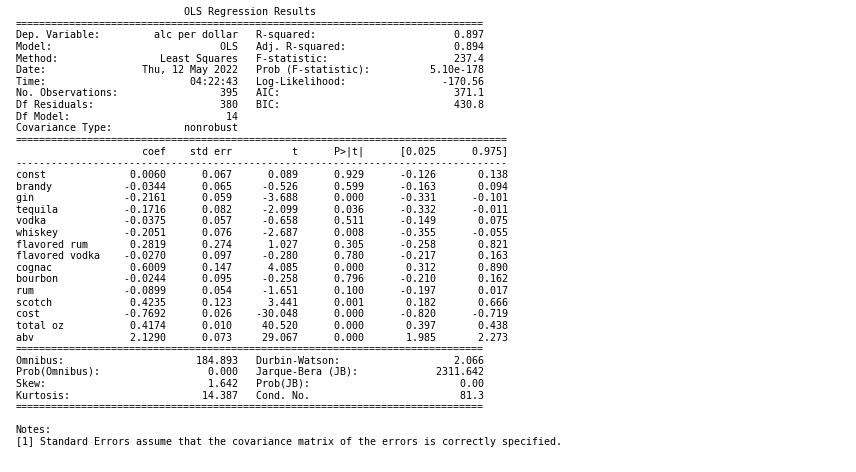

In [35]:
ols_price_on_liquor()

In [244]:
# def ols_number_ingreds_on_liquor():
#     """Perform OLS regression of movie Revenue on IMBD Rating and genre dummies, and create png"""

#     df = model_1()
#     x_cols = ["brandy","vodka","tequila","whiskey","flavored rum","flavored vodka","cognac","bourbon","rum","scotch","grain alcohol", "total oz"]
#     x = df[x_cols]
#     y = df["number of ingredients"]
#     display(df[x_cols])
#     model = sm.OLS(y, sm.add_constant(x)).fit()
#     model_summary = model.summary()
#     fig, ax = plt.subplots(figsize=(12, 7))
#     ax.text(
#         0.01, 0.05, str(model_summary), {"fontsize": 10}, fontproperties="monospace"
#     )
#     ax.axis("off")
#     plt.tight_layout()

In [132]:
def save_plot(figure_obj, output_directory, output_file_name):
    """Function takes in a figure, the output directory and file name and saves the figure"""
    path = os.path.join(output_directory, output_file_name)
    figure_obj.savefig(path)


In [229]:
def check_covar_costs():
    df_prices = pd.read_csv(INPUT_PATH, header=None)
    df_prices = df_prices.transpose()
    df_prices.columns = df_prices.loc[0]
    df_prices = df_prices.drop(0)
    df_prices = df_prices[["brandy","gin","tequila","vodka","whiskey","flavored rum","flavored vodka","cognac","bourbon","rum","scotch","grain alcohol"]]
    plot = df_prices.plot.bar(figsize=(15,4),title="Summary of Liquor Cost")
    plot = plot.set(xlabel="Type of Liquor",ylabel="Cost Per Ounce")
    return plot

In [ ]:
if __name__ == "__main__":
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    save_plot(figure_obj, output_directory, output_file_name)
    
    